Author: Carlos Roberto de Melo

Date: 06/01/2020

Obj:
1. Cortar as imagens originais.
2. Fazer uso do código aberto Astroalign para remover qualquer tipo de offset entre as diferentes bandas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from mpdaf.obj import Image, WCS
from mpdaf.obj import deg2sexa, sexa2deg

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/Alignment/Data/"

In [2]:
#Abre as imagens originais .fits
hst  = Image(data_folder+"hst_12194_01_wfc3_ir_f160w_drz.fits")
muse = Image(data_folder+"Muse.fits")


In [3]:
#Mostra as informações relevantes de cada imagem
hst.info()
muse.info()

[INFO] 2036 x 2067 Image (/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/Alignment/Data/hst_12194_01_wfc3_ir_f160w_drz.fits)
[INFO] .data(2036 x 2067) (no unit), no noise
[INFO] center:(00:39:06.5657,09:03:12.1281) size:(183.240",186.030") step:(0.090",0.090") rot:0.0 deg frame:FK5
[INFO] 250 x 250 Image (/home/carlos/Documents/GitHub/Master-Degree/SDP81/Dynamics/Alignment/Data/Img.fits)
[INFO] .data(250 x 250) (1e-20 erg / (Angstrom cm2 s)), .var(250 x 250)
[INFO] center:(00:39:07.0985,09:03:11.6099) size:(50.000",50.000") step:(0.200",0.200") rot:-0.0 deg frame:FK5


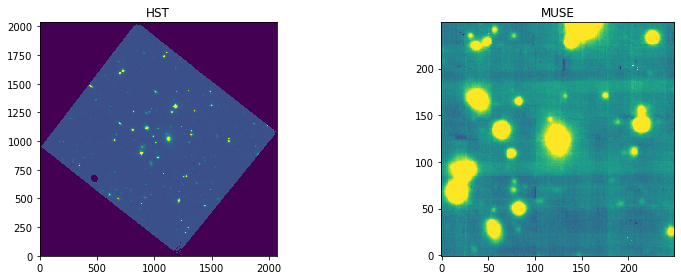

In [4]:
#Plota as imagens
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

hst.plot(ax=ax1, zscale=True, title='HST')
muse.plot(ax=ax2, zscale=True, title='MUSE')

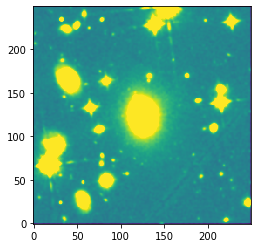

In [5]:
#Aqui é feito um resampling para que ambas as imagens tenham o mesmo pixel scale
ima2muse = hst.align_with_image(muse)
ima2muse.plot(zscale=True)

In [6]:
#Salvamos a imagem resampled
ima2muse.write(data_folder+"hst_cut.fits")

Os próximos blocos farão uso das imagens recortadas acima para buscar (e eventualemente corrigir) offsets. Isso é feito pelo código aberto **Astroaligns** disponível em https://astroalign.readthedocs.io/en/latest/

In [7]:
import astroalign as aa
import pandas as pd
from astropy.io import fits

In [8]:
hst = fits.open(data_folder+"hst_cut.fits") #Abre a imagem .fits
hst_data = hst[1].data #Coleta os dados
hst_header = hst[1].header #Abre o header
hst_data = hst_data.byteswap().newbyteorder() #Necessário por conpatibilidade 32/64 bits

muse = fits.open(data_folder+"Muse.fits")
muse_data = muse[1].data
muse_header = muse[1].header
muse_data = muse_data.byteswap().newbyteorder()

In [9]:
#Realiza o registro com o astroalign/Solve registration with astroalign
#Aqui estamos usando a imagem f814w como referência para a imagem f475w
muse_aligned, footprint = aa.register(muse_data, hst_data,min_area=0.2)

#Printa a informação com os pontos usados para realizar o registro
p, (pos_img, pos_img_rot) = aa.find_transform(muse_data, hst_data)
print("Rotation: {:.2f} degrees".format(p.rotation * 180.0 / np.pi))
print("\nScale factor: {:.2f}".format(p.scale))
print("\nTranslation: (x, y) = ({:.2f}, {:.2f})".format(*p.translation))
print("\nTranformation matrix:\n{}".format(p.params))
print("\nPoint correspondence:")
for (x1, y1), (x2, y2) in zip(pos_img, pos_img_rot):
    print("({:.2f}, {:.2f}) in source --> ({:.2f}, {:.2f}) in target"
          .format(x1, y1, x2, y2))

Rotation: -0.10 degrees

Scale factor: 1.00

Translation: (x, y) = (0.64, -1.21)

Tranformation matrix:
[[ 1.00077769  0.00182867  0.63790455]
 [-0.00182867  1.00077769 -1.21211704]
 [ 0.          0.          1.        ]]

Point correspondence:
(213.71, 154.91) in source --> (214.85, 153.71) in target
(55.85, 27.64) in source --> (56.70, 26.45) in target
(82.78, 50.59) in source --> (83.69, 49.35) in target
(74.52, 109.13) in source --> (75.45, 108.04) in target
(57.06, 241.25) in source --> (58.18, 240.28) in target
(37.16, 224.30) in source --> (38.00, 223.45) in target
(77.49, 234.98) in source --> (78.51, 234.01) in target
(205.63, 111.07) in source --> (206.63, 109.89) in target
(39.01, 166.68) in source --> (40.07, 165.27) in target
(31.24, 234.56) in source --> (32.13, 234.24) in target
(138.38, 228.73) in source --> (138.46, 227.99) in target
(48.36, 228.35) in source --> (49.51, 227.43) in target
(124.08, 124.10) in source --> (125.58, 123.04) in target
(16.17, 68.53) in sourc

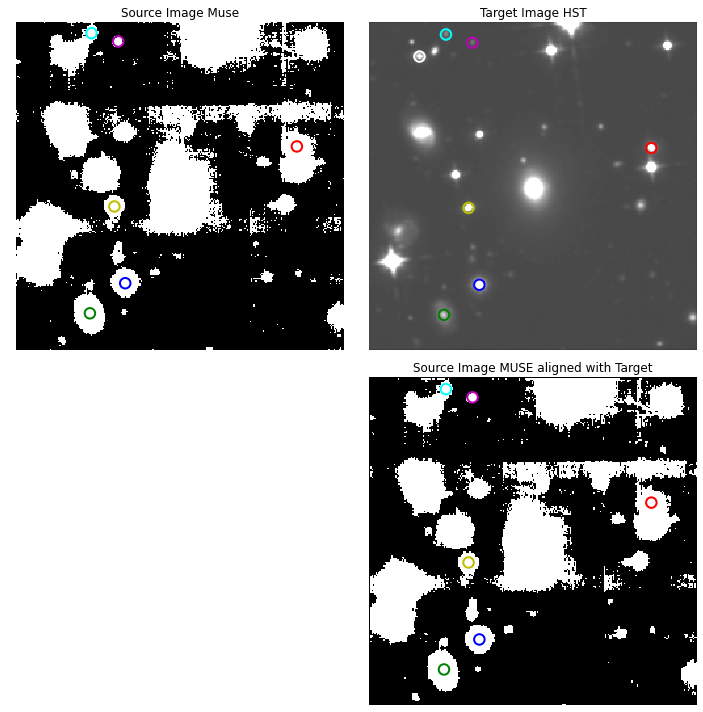

In [10]:
#Plota as imagens antes e depois do registro, além de marcar quais pontos foram usados para tal

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

colors = ['r', 'g', 'b', 'y', 'cyan', 'w', 'm']

axes[0, 0].imshow(muse_data, cmap='gray', interpolation='none', origin='lower', vmin=0,vmax=1)
axes[0, 0].axis('off')
axes[0, 0].set_title("Source Image Muse")
for (xp, yp), c in zip(pos_img[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4, fill=False, edgecolor=c, linewidth=2)
    axes[0, 0].add_patch(circ)

axes[0, 1].imshow(hst_data, cmap='gray', interpolation='none', origin='lower',vmin=0, vmax=1)
axes[0, 1].axis('off')
axes[0, 1].set_title("Target Image HST")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[0, 1].add_patch(circ)

axes[1, 1].imshow(muse_aligned, cmap='gray', interpolation='none', origin='lower',vmin=0, vmax=1)
axes[1, 1].axis('off')
axes[1, 1].set_title("Source Image MUSE aligned with Target")
for (xp, yp), c in zip(pos_img_rot[:len(colors)], colors):
    circ = plt.Circle((xp, yp), 4 * p.scale, fill=False, edgecolor=c, linewidth=2)
    axes[1, 1].add_patch(circ)

axes[1, 0].axis('off')
plt.tight_layout()
plt.show()

In [11]:
#salvando a imagem Muse alinhada com a do HST
header_new = muse_header
new = fits.PrimaryHDU(muse_aligned,header=header_new)
hdul = fits.HDUList([new])
hdul.writeto(data_folder+"Muse_aligned.fits", overwrite=True)